In [155]:
import albumentations as A
import cv2
import os
import copy
import matplotlib.pyplot as plt

In [156]:
class Data:
	rotate90_transform = A.Compose([
		A.Affine(rotate=[90, 90], p=1, mode=cv2.BORDER_CONSTANT, fit_output=True)
	], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

	rotate180_transform = A.Compose([
		A.Affine(rotate=[180, 180], p=1, mode=cv2.BORDER_CONSTANT, fit_output=True)
	], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

	rotate270_transform = A.Compose([
		A.Affine(rotate=[270, 270], p=1, mode=cv2.BORDER_CONSTANT, fit_output=True)
	], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

	blur_transform = A.Compose([
		A.Blur(blur_limit=31, p=1),
	], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

	dark_transform = A.Compose([
		A.RandomBrightnessContrast(limit=[-0.2,-0.2], p=1),
	], bbox_params=A.BboxParams(format="yolo", label_fields=['class_labels']))

	noise_transform = A.Compose([
		A.ISONoise(intensity=(0.1, 0.1), p=1),
	], bbox_params=A.BboxParams(format="yolo", label_fields=['class_labels']))

	def __init__(self, image="", bboxes=0, id="", class_labels=[]):
		self.image = image
		self.bboxes = bboxes
		self.id = id
		self.class_labels = class_labels

	def importdata(self, imgpath):
		dirpath = os.path.dirname(imgpath)
		id = os.path.splitext(os.path.basename(imgpath))[0]
		txtpath = dirpath + f"/{id}.txt"

		img = cv2.imread(imgpath)
		self.image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

		bboxes = []
		class_labels = []

		with open(txtpath) as f:
			for line in f:
				line_list = line.split()
				class_labels.append(line_list[0])
				bbox = [float(i) for i in line_list[1:]]
				bboxes.append(bbox)

		self.bboxes = bboxes
		self.label = 0
		self.id = id
		self.class_labels = class_labels
		print(self.class_labels)

	# albumentationsで変換したデータをインポートするメソッド
	def import_transformdata(self, transform_data, origin_data, process):
		self.image = transform_data["image"]
		self.bboxes = transform_data["bboxes"]
		self.label = 0
		self.id = origin_data.id + "_" + process
		self.class_labels = transform_data["class_labels"]
	
	def rotate90(self):
		rotate90_transformed = Data.rotate90_transform(image=self.image, bboxes=self.bboxes, class_labels=self.class_labels)

		image = rotate90_transformed['image']
		bboxes = rotate90_transformed['bboxes']
		id = self.id + "_rot90"
		class_labels = rotate90_transformed['class_labels']
		rot90data = Data(image, bboxes, id, class_labels)
		return rot90data

	def export_data(self, imgdirpath):
		id = self.id
		dirpath = imgdirpath
		export_imgpath = dirpath + f"/{id}.jpg"
		export_txtpath = dirpath + f"/{id}.txt"

		img = cv2.cvtColor(self.image, cv2.COLOR_RGB2BGR)
		cv2.imwrite(export_imgpath, img)

		txt = ""
		for class_label, bbox in zip(self.class_labels, self.bboxes):
			x_min, y_min, width, height = [i for i in bbox]
			line = f"{class_label} {x_min} {y_min} {width} {height}"
			txt += line + "\n"
			print(line)

		f = open(export_txtpath, 'w')
		f.write(txt) 
		f.close()

	
# 画像とバウンディングボックスを表示するメソッド
	def visualize(self, img_width, img_height, figsize = (10,10)):
		for bbox in self.bboxes:
				x_mid_nor, y_mid_nor, width_nor, height_nor  = [float(i) for i in bbox]

				width = width_nor * img_width  
				height = height_nor * img_height   

				x_min = x_mid_nor * img_width - width/2   
				y_min = y_mid_nor * img_height - height/2    
				x_max = x_min + width
				y_max = y_min + height

				x_min = int(x_min)
				x_max = int(x_max)
				y_min = int(y_min)
				y_max = int(y_max)

				img = cv2.rectangle(self.image,
													pt1=(x_min, y_min),
													pt2=(x_max, y_max),
													color=(255, 0, 0),
													thickness=3)

		plt.figure(figsize = figsize)
		plt.axis('off')
		plt.imshow(img)


C:\Users\yukit\AppData\Local\Temp\ipykernel_3352\1759818331.py:3: UserWarning: Argument(s) 'mode' are not valid for transform Affine
  A.Affine(rotate=[90, 90], p=1, mode=cv2.BORDER_CONSTANT, fit_output=True)
C:\Users\yukit\AppData\Local\Temp\ipykernel_3352\1759818331.py:7: UserWarning: Argument(s) 'mode' are not valid for transform Affine
  A.Affine(rotate=[180, 180], p=1, mode=cv2.BORDER_CONSTANT, fit_output=True)
C:\Users\yukit\AppData\Local\Temp\ipykernel_3352\1759818331.py:11: UserWarning: Argument(s) 'mode' are not valid for transform Affine
  A.Affine(rotate=[270, 270], p=1, mode=cv2.BORDER_CONSTANT, fit_output=True)
c:\Users\yukit\development\coinRecognition\.venv\Lib\site-packages\albumentations\core\composition.py:250: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
C:\Users\yukit\AppData\Local\Temp\ipykernel_3352\1759818331.py:19: UserWarning: Argument(s) 'limit' are not valid for transform RandomBrightnessContrast
  A.RandomBrightne

In [157]:
data = Data()
imgpath = "./coin/one/000002.jpg"
data.importdata(imgpath)

['0', '0', '0', '0', '0']


In [158]:
dataset_origin = []
print(os.getcwd())
imgdirpath = "./coin/one"

target = ["000002.jpg", "000005.jpg", "000056.jpg"]

for filename in os.listdir(imgdirpath):
	if filename.endswith(".txt"):
		continue
	if filename not in target:
		continue
	fullpath = imgdirpath + "/" + filename # ex) ./coin/one/000002.jpg
	data = Data()
	data.importdata(fullpath)
	dataset_origin.append(data)

dataset = copy.deepcopy(dataset_origin)

c:\Users\yukit\development\coinRecognition
['0', '0', '0', '0', '0']
['0', '0']
['0', '0', '1', '2']


0 0.4485978469763219 0.512167802558536 0.6261681428765211 0.4159293805075958
0 0.6370712165891939 0.1349553080786646 0.5919000044047276 0.2588495480275787
0 0.538940454754874 0.825221456851052 0.6199372464622663 0.33849557878169345
0 0.8520245706180918 0.7842923714655691 0.16822428161110092 0.42035374955265925
0 0.8707163417450736 0.3506636010334555 0.12461070182538847 0.37168106146618335
0 0.5331512070297265 0.6998954769970538 0.5967236309081271 0.3961476778251811
0 0.5269109484929935 0.3084333460508443 0.6014043120623751 0.3711606710295948
0 0.5918863947282387 0.7731360003893285 0.3183079294953367 0.17180788754392817
0 0.37829404796542143 0.4709100779124137 0.2531204144270179 0.1710271630516187
1 0.33356413910689864 0.6735648945037949 0.2704573355501469 0.1741509845321042
2 0.6612340792207545 0.5573992745944273 0.3183079294953367 0.1987503450952997


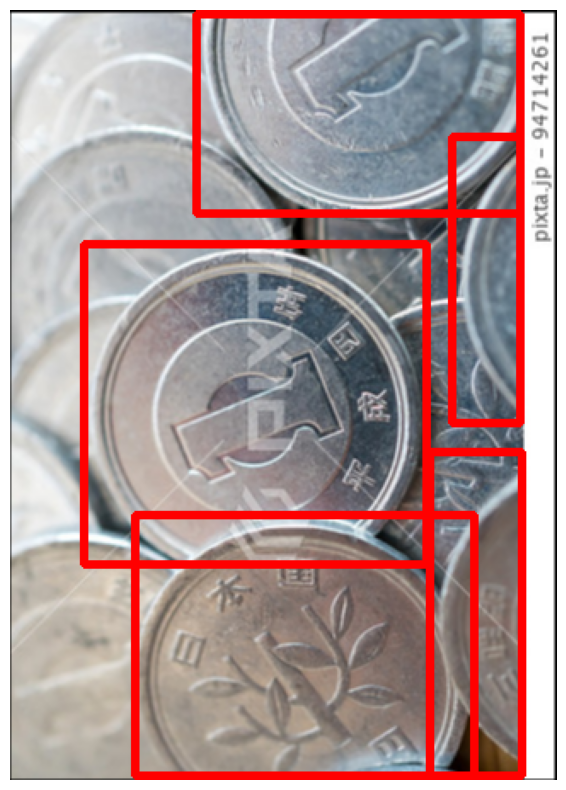

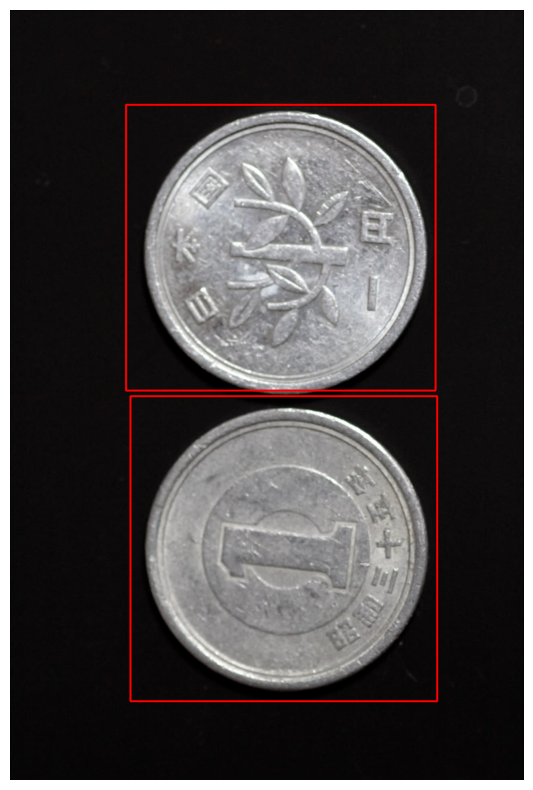

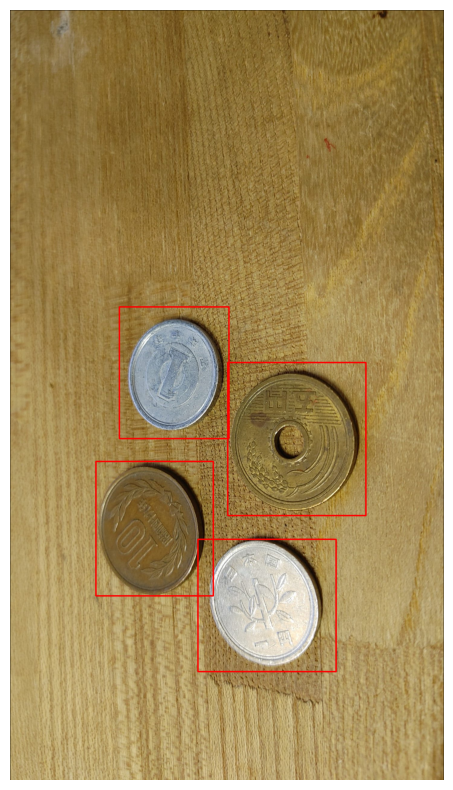

In [159]:
rotate90_data = []
for data in dataset_origin:
  transformed = data.rotate90()
  rotate90_data.append(transformed)

export_dir = "./coin/one/rotated"
os.makedirs(export_dir, exist_ok=True)

# 各変換後データを export_data を用いて保存
for data in rotate90_data:
    width, height, _ = data.image.shape
    data.visualize(height, width)
    data.export_data(export_dir)